# Image classification 

Importing dependencies

In [156]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr

Removing doddgy images from dataset

In [158]:
data_dir = 'data3' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

loading the data 

In [226]:
data = tf.keras.utils.image_dataset_from_directory('data2')

Found 1957 files belonging to 2 classes.


In [227]:
data_iterator = data.as_numpy_iterator()

In [228]:
batch = data_iterator.next()


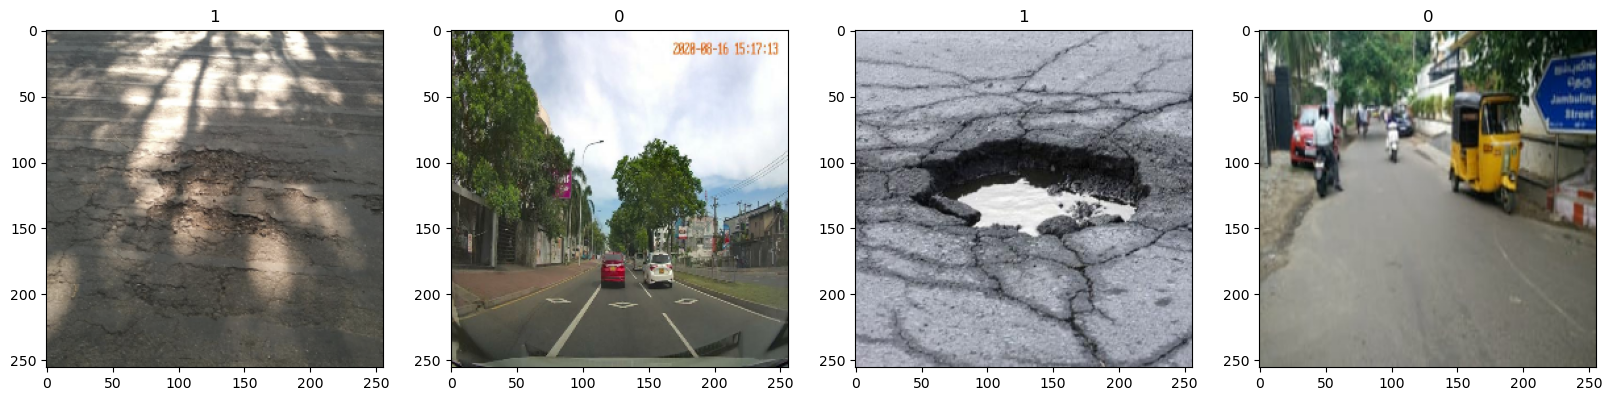

In [229]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Scaling the data 

In [230]:
data = data.map(lambda x,y: (x/255, y))

In [231]:
scaled_iterator= data.as_numpy_iterator()

In [232]:
batch = scaled_iterator.next()

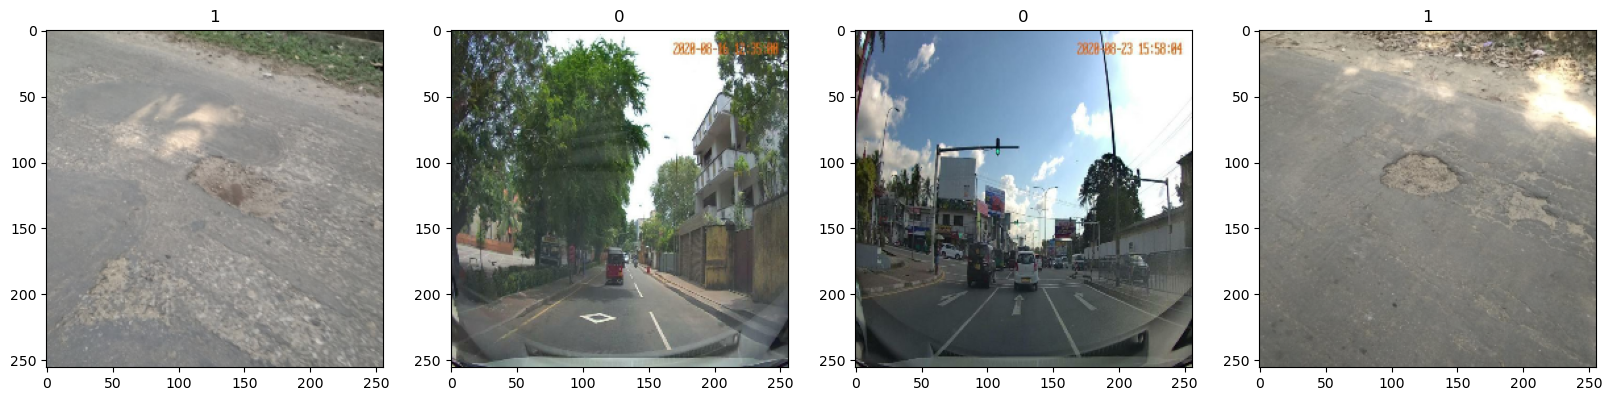

In [233]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Splitting data

In [234]:
#assigning a size for the dataset
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [235]:
#assigning data based on the previously assigned size
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Building the nueral network

In [170]:
#importing dependecies for the nueral network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [171]:
model = Sequential()

Nueral net's architechture

In [172]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [173]:
#analyze the accuracy
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [174]:
#view the neural nets archeticture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

Training the neural net

In [175]:
logdir='logs'

In [176]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [177]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>0.99):
      print("\n 99% accuracy reached so cancelling training")
      self.model.stop_training=True

In [178]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback,mycallback()])

Epoch 1/20
76/76 [==============================] - 110s 1s/step - loss: 0.5080 - accuracy: 0.7171 - val_loss: 0.0980 - val_accuracy: 0.9598
Epoch 2/20
76/76 [==============================] - 130s 2s/step - loss: 0.0911 - accuracy: 0.9679 - val_loss: 0.0738 - val_accuracy: 0.9777
Epoch 3/20
76/76 [==============================] - 137s 2s/step - loss: 0.0693 - accuracy: 0.9778 - val_loss: 0.0311 - val_accuracy: 0.9881
Epoch 4/20
76/76 [==============================] - 59s 735ms/step - loss: 0.0397 - accuracy: 0.9860 - val_loss: 0.0412 - val_accuracy: 0.9926
Epoch 5/20
76/76 [==============================] - 35s 449ms/step - loss: 0.0488 - accuracy: 0.9827 - val_loss: 0.0133 - val_accuracy: 0.9940
Epoch 6/20
76/76 [==============================] - 35s 453ms/step - loss: 0.0374 - accuracy: 0.9868 - val_loss: 0.0544 - val_accuracy: 0.9911
Epoch 7/20
76/76 [==============================] - 48s 629ms/step - loss: 0.0321 - accuracy: 0.9893 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch

plotting preformence

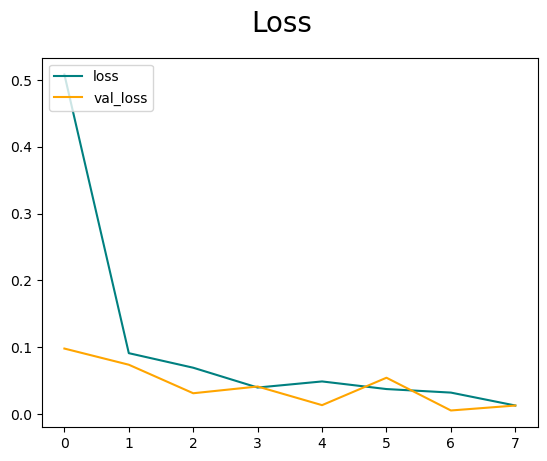

In [179]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

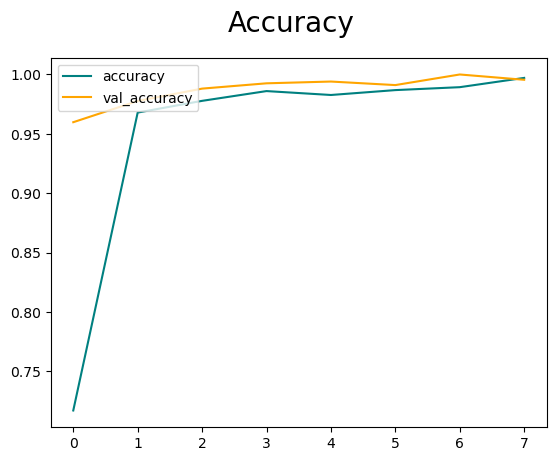

In [180]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluation

In [181]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [182]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [183]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 210ms/step


In [184]:

print(f"precision: {pre.result().numpy()*100}% recall: {re.result().numpy()*100}% accuracy: {acc.result().numpy()*100}%") 

precision: 100.0% recall: 100.0% accuracy: 100.0%


testing

<function matplotlib.pyplot.show(close=None, block=None)>

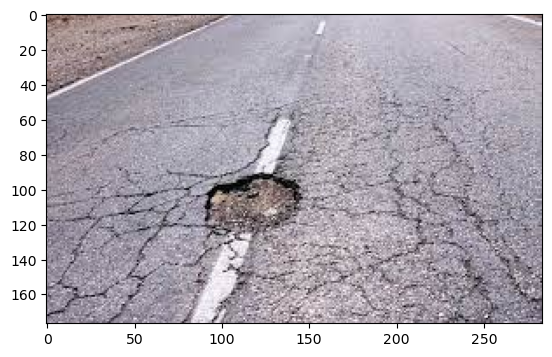

In [247]:
img = cv2.imread("pothole.jpeg")
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show

In [248]:
resizedIMG = tf.image.resize(img,(256,256))


In [249]:
yhat = model.predict(np.expand_dims(resizedIMG/255,0))

1/1 [==============================] - 0s 59ms/step


In [250]:
if yhat >= 0.5 :
    print(f'image has a pothole probability of pothole {yhat[0][0]*100}%')
else:
    print(f'no pothole in image probability of pothole {yhat[0][0]*100}%')
    

image has a pothole probability of pothole 100.0%


# Saving the Model

In [189]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

loading the saved model and further testing

In [217]:
new_model = load_model('./models/imageclassifier.h5')

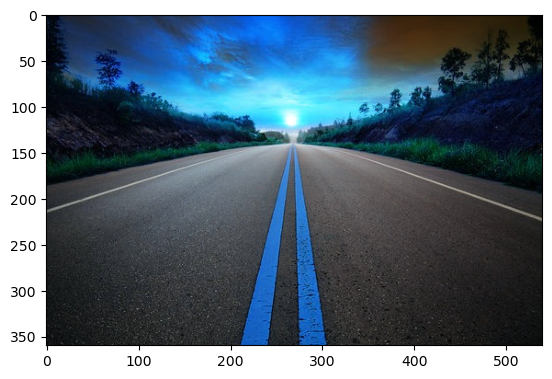

In [218]:
img = input('enter image path')
img = cv2.imread(img)
plt.imshow(img)


In [221]:
resizedIMG = tf.image.resize(img,(256,256))
yhat = new_model.predict(np.expand_dims(resizedIMG/255,0))

1/1 [==============================] - 3s 3s/step


In [225]:
if yhat >= 0.5 :
    print(f'image has a pothole probability of pothole {yhat[0][0]*100}%')
else:
    print(f'no pothole in image probability of pothole {yhat[0][0]*100}%')
    

no pothole in image probability of pothole 0.6463293917477131%
